## 1D Diffusion Equation PINN

Based on what was shown in the previous notebook, we now attempt to solve the 1-dimensional diffusion equation on a rod of length $L$:

$$ \frac{\partial u\left(t,x\right)}{\partial t} - D \frac{\partial^2 u\left(t,x\right)}{\partial x^2} = 0, \hspace{10mm} \left(t,x\right) \in [0,1]\times\left[0,L\right], $$

subject to the following initial and boundary conditions

$$ u\left(t=0,x\right) = \sin\left(\pi x\right), \hspace{10mm} x \in \left[0,L\right], $$

$$ u\left(t,x=0\right) = u\left(t,x=L\right) = 0, \hspace{10mm} t \in \left[0,1\right]. $$

For the parameters $L$ and $D$ we choose the values $L=1$ and $D=0.15$, respectively.

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import optax
import flax.linen as nn

from typing import Sequence

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

We setup the grid, as well as the ICs/BCs.

In [2]:
N_0, N_b1, N_b2, N_f = 100, 100, 100, 10_000

# Domains of t and x
tmin, tmax = 0.0, 1.0
xmin, xmax = 0.0, 1.0

# seed key for debugging
np.random.seed(420)

# ------------------------------------------
# Initial Condition (IC): u(t=0,x) = sin(pi*x)
# ------------------------------------------

t_0 = jnp.ones([N_0,1],dtype='float32')*0.0
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
ic_0 = jnp.sin(jnp.pi*x_0)
IC_0 = jnp.concatenate([t_0,x_0,ic_0],axis=1)

# ------------------------------------------
# Boundary condition (BC) #1: u(t,x=0) = 0
# ------------------------------------------

t_b1 = np.random.uniform(low=tmin,high=tmax,size=(N_b1,1))
x_b1 = jnp.zeros_like(t_b1)
bc_1 = jnp.zeros_like(t_b1)
BC_1 = jnp.concatenate([t_b1,x_b1,bc_1],axis=1)

# ------------------------------------------
# Boundary condition (BC) #2: u(t,x=1) = 0
# ------------------------------------------

t_b2 = np.random.uniform(low=tmin,high=tmax,size=(N_b2,1))
x_b2 = jnp.ones_like(t_b2)
bc_2 = jnp.zeros_like(t_b2)
BC_2 = jnp.concatenate([t_b2,x_b2,bc_2],axis=1)

conds = [IC_0,BC_1,BC_2]

t_c = np.random.uniform(low=tmin,high=tmax,size=(N_f,1))
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_f,1))

colloc = jnp.concatenate([t_c,x_c],axis=1)

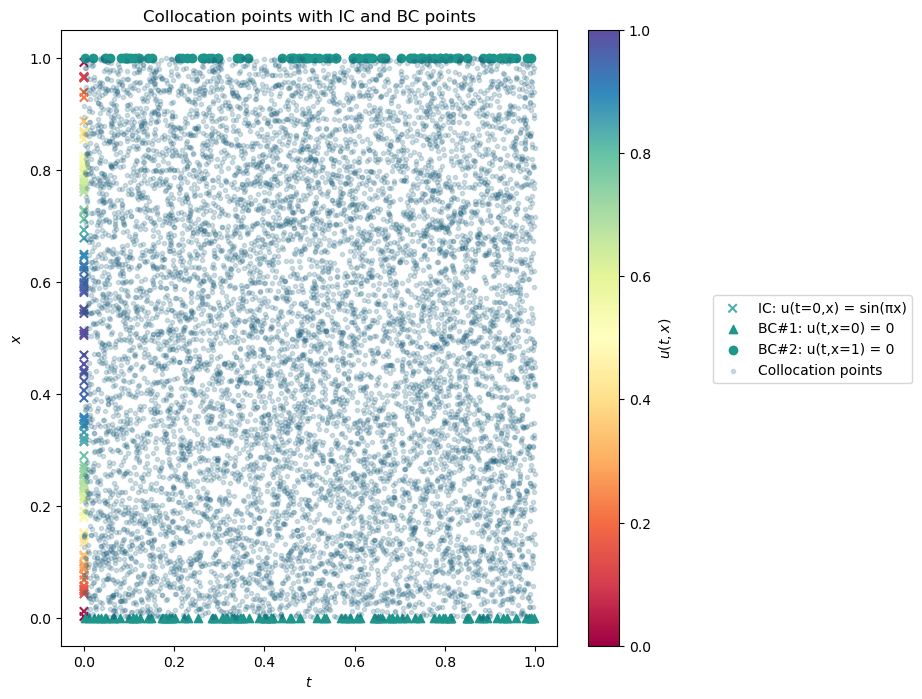

In [3]:
fig = plt.figure(figsize=(8,8))

cmap = 'Spectral'

plt.scatter(t_0, x_0, c=ic_0, marker='x', vmin=0, vmax=1, label='IC: u(t=0,x) = sin(πx)', cmap=cmap)
plt.scatter(t_b1, x_b1, color='#1f968b', marker='^', label='BC#1: u(t,x=0) = 0')
plt.scatter(t_b2, x_b2, color='#1f968b', marker='o', label='BC#2: u(t,x=1) = 0')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)

plt.scatter(t_c, x_c, color='#1a5d7b', marker='.', alpha=0.2, label='Collocation points')
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')

plt.title('Collocation points with IC and BC points')

cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap))
cbar.set_label(r'$u(t,x)$', rotation=90)

plt.legend(bbox_to_anchor=(1.3, 0.58))
plt.show()

Define the required functions (see previous Notebook for more info).

In [4]:
class MLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.layers = [nn.Dense(features=feat, use_bias=True) for feat in self.features]
        
    def __call__(self, inputs):
        x = inputs
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if idx != len(self.layers)-1:
                x = jnp.tanh(x)
        return x

In [5]:
@jax.jit
def MSE(true,pred):
    return jnp.mean((true-pred)**2)
    
def PINN_f(t,x,ufunc):
    u_x = lambda t,x : jax.grad(lambda t,x : jnp.sum(ufunc(t,x)),1)(t,x)
    u_xx = lambda t,x : jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)(t,x)
    u_t = lambda t,x : jax.grad(lambda t,x : jnp.sum(ufunc(t,x)),0)(t,x)
    return u_t(t,x) - 0.15*u_xx(t,x)
    
@jax.jit
def uNN(params,t,x):
    u = model.apply(params, jnp.concatenate((t,x),axis=1))
    return u

def loss_fun(params,colloc,conds):
    t_c, x_c = colloc[:,[0]], colloc[:,[1]]
    ufunc = lambda t,x : uNN(params,t,x)
    mse_f = jnp.mean(PINN_f(t_c,x_c,ufunc)**2)

    mse_u = 0.0
    for cond in conds:
        t_b, x_b, u_b = cond[:,[0]], cond[:,[1]], cond[:,[2]]
        mse_u += MSE(u_b,ufunc(t_b,x_b))
    return mse_f + mse_u

@jax.jit
def update(opt_state,params,colloc,conds):
    # Get the gradient w.r.t to MLP params
    grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Apply the update
    params = optax.apply_updates(params, updates)

    return opt_state, params

def init_process(features):
    
    model = MLP(features)

    key1, key2 = jax.random.split(jax.random.PRNGKey(420),num=2)

    dummy_in = jax.random.normal(key1, (2,))
    params = model.init(key2, dummy_in)

    lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    
    return model, params, optimizer, opt_state

def plot_results(T, X, results):
    fig, ax = plt.subplots(figsize=(8,5))

    c = ax.pcolormesh(T, X, results, cmap='Spectral')

    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.title('PINN Solution of the PDE')

    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label(r'$u(t,x)$', rotation=90)

    plt.show()

Initialize and train the model.

In [6]:
features = [8, 8, 8, 8, 8, 8, 1]

model, params, optimizer, opt_state = init_process(features)

In [7]:
%%time
epochs = 10_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,colloc,conds)

    # print loss and epoch info
    if epoch%(1000) ==0:
        print(f'Epoch={epoch}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=3.628e-01
Epoch=1000	loss=2.179e-04
Epoch=2000	loss=1.136e-04
Epoch=3000	loss=5.087e-05
Epoch=4000	loss=3.972e-05
Epoch=5000	loss=3.037e-05
Epoch=6000	loss=4.176e-05
Epoch=7000	loss=1.304e-04
Epoch=8000	loss=7.012e-05
Epoch=9000	loss=1.633e-05
CPU times: user 13 s, sys: 3.99 s, total: 17 s
Wall time: 14.7 s


Visualize the results.

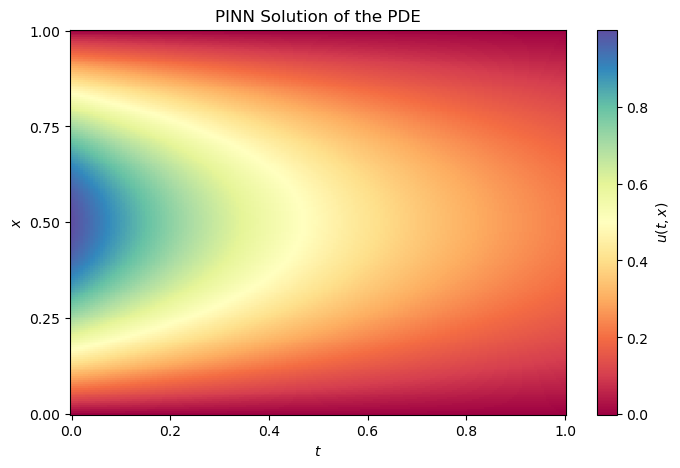

In [8]:
N = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N)
xspace = np.linspace(xmin, xmax, N)
T, X = np.meshgrid(tspace, xspace)

results = uNN(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1)).reshape(N,N)

plot_results(T, X, results)

The analytic solution of this equation is

$$ u_{exact}\left(t,x\right) = \sin\left(\pi x\right)\cdot \exp\left(-0.15\pi^2 t\right) $$

and the corresponding visualization is shown in the figure below.

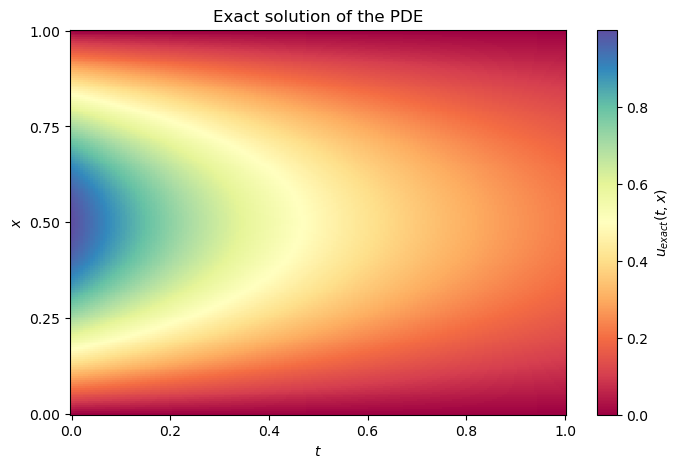

In [9]:
def analytic_u(t,x):
    return np.sin(np.pi*x)*np.exp(-0.15*(np.pi**2)*t)

N = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N)
xspace = np.linspace(xmin, xmax, N)
T, X = np.meshgrid(tspace, xspace)

analytic_results = analytic_u(T.flatten().reshape(-1,1),X.flatten().reshape(-1,1)).reshape(N,N)

fig, ax = plt.subplots(figsize=(8,5))
c = ax.pcolormesh(T, X, analytic_results, cmap='Spectral')

plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.title('Exact solution of the PDE')

cbar = plt.colorbar(c, ax=ax)
cbar.set_label(r'${u_{exact}}(t,x)$', rotation=90)

plt.show()

By visual inspection, it appears that the two solutions are practically equal. However, to get a more solid confirmation, we plot the differences of the two plots:

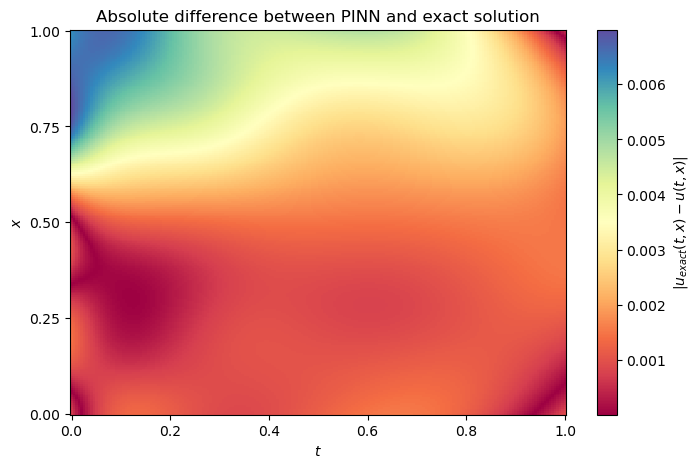

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
c = ax.pcolormesh(T, X, abs(analytic_results-results), cmap='Spectral')

plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
plt.title('Absolute difference between PINN and exact solution')

cbar = plt.colorbar(c, ax=ax)
cbar.set_label(r'$|{u_{exact}}(t,x) - u(t,x)|$', rotation=90)

plt.show()

It becomes evident that the two solutions are indeed very close to each other, since the maximum difference is $\mathcal{O}\left(10^{-3}\right)$.

## 2D Diffusion Equation PINN

The next logical step is to move on to the 2D diffusion equation, i.e.

$$ \frac{1}{D}\frac{\partial u\left(t,x,y\right)}{\partial t} - \frac{\partial^2 u\left(t,x,y\right)}{\partial x^2} - \frac{\partial^2 u\left(t,x,y\right)}{\partial y^2} = 0, \hspace{10mm} \left(t,x,y\right) \in [0,1]\times\left[0,L_x\right]\times\left[0,L_y\right], $$

subject to the following initial and boundary conditions

$$ u\left(t=0,x,y\right) = \sin\left(\pi x\right)\sin\left(\pi y\right), \hspace{10mm} x \in \left[0,L_x\right], \hspace{4mm} y \in \left[0,L_y\right], $$

$$ u\left(t,x=0,y\right) = u\left(t,x=L_x,y\right) = u\left(t,x,y=0\right) = u\left(t,x,y=L_y\right) = 0, \hspace{10mm} t \in \left[0,1\right]. $$

For the parameters $L_x$, $L_y$ and $D$ we choose the values $L_x=1$, $L_y=1$ and $D=0.15$, respectively.

In [11]:
N_0, N_b1, N_b2, N_b3, N_b4, N_f = 1500, 1000, 1000, 1000, 1000, 100_000

# Domains of t, x and y
tmin, tmax = 0.0, 1.0
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

# seed key for debugging
np.random.seed(420)

# ---------------------------------------------------------
# Initial Condition (IC): u(t=0,x,y) = sin(pi*x)*sin(pi*y)
# ---------------------------------------------------------

t_0 = jnp.ones([N_0,1],dtype='float32')*0.0
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
y_0 = np.random.uniform(low=ymin,high=ymax,size=(N_0,1))
ic_0 = jnp.sin(jnp.pi*x_0)*jnp.sin(jnp.pi*y_0)
IC_0 = jnp.concatenate([t_0,x_0,y_0,ic_0],axis=1)

# ------------------------------------------
# Boundary condition (BC) #1: u(t,x=0,y) = 0
# ------------------------------------------

t_b1 = np.random.uniform(low=tmin,high=tmax,size=(N_b1,1))
x_b1 = jnp.zeros_like(t_b1)
y_b1 = np.random.uniform(low=ymin,high=ymax,size=(N_b1,1))
bc_1 = jnp.zeros_like(t_b1)
BC_1 = jnp.concatenate([t_b1,x_b1,y_b1,bc_1],axis=1)

# ------------------------------------------
# Boundary condition (BC) #2: u(t,x=1,y) = 0
# ------------------------------------------

t_b2 = np.random.uniform(low=tmin,high=tmax,size=(N_b2,1))
x_b2 = jnp.ones_like(t_b2)
y_b2 = np.random.uniform(low=ymin,high=ymax,size=(N_b2,1))
bc_2 = jnp.zeros_like(t_b2)
BC_2 = jnp.concatenate([t_b2,x_b2,y_b2,bc_2],axis=1)

# ------------------------------------------
# Boundary condition (BC) #3: u(t,x,y=0) = 0
# ------------------------------------------

t_b3 = np.random.uniform(low=tmin,high=tmax,size=(N_b3,1))
x_b3 = np.random.uniform(low=xmin,high=xmax,size=(N_b3,1))
y_b3 = jnp.zeros_like(t_b3)
bc_3 = jnp.zeros_like(t_b3)
BC_3 = jnp.concatenate([t_b3,x_b3,y_b3,bc_3],axis=1)

# ------------------------------------------
# Boundary condition (BC) #4: u(t,x,y=1) = 0
# ------------------------------------------

t_b4 = np.random.uniform(low=tmin,high=tmax,size=(N_b4,1))
x_b4 = np.random.uniform(low=xmin,high=xmax,size=(N_b4,1))
y_b4 = jnp.ones_like(t_b4)
bc_4 = jnp.zeros_like(t_b4)
BC_4 = jnp.concatenate([t_b4,x_b4,y_b4,bc_4],axis=1)

conds = [IC_0,BC_1,BC_2,BC_3,BC_4]

t_c = np.random.uniform(low=tmin,high=tmax,size=(N_f,1))
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_f,1))
y_c = np.random.uniform(low=ymin,high=ymax,size=(N_f,1))

colloc = jnp.concatenate([t_c,x_c,y_c],axis=1)

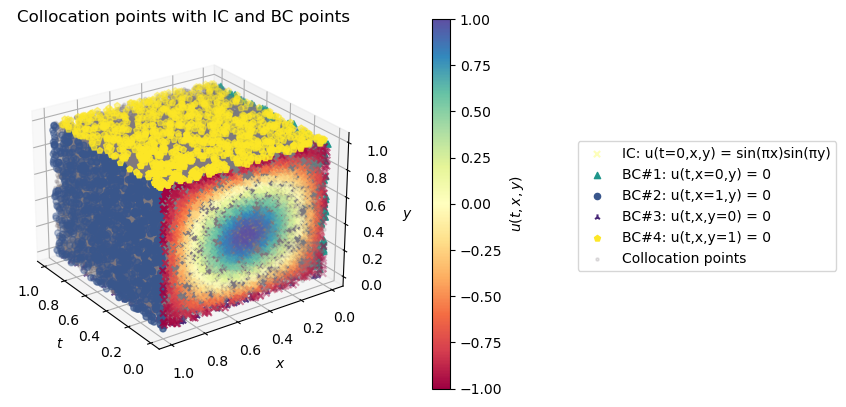

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = 'Spectral'

ax.scatter(t_0, x_0, y_0, c=ic_0, marker='x', label='IC: u(t=0,x,y) = sin(πx)sin(πy)', cmap=cmap)
ax.scatter(t_b1, x_b1, y_b1, color='#1f968b', marker='^', label='BC#1: u(t,x=0,y) = 0')
ax.scatter(t_b2, x_b2, y_b2, color='#39568c', marker='o', label='BC#2: u(t,x=1,y) = 0')
ax.scatter(t_b3, x_b3, y_b3, color='#482677', marker='2', label='BC#3: u(t,x,y=0) = 0')
ax.scatter(t_b4, x_b4, y_b4, color='#fde726', marker='p', label='BC#4: u(t,x,y=1) = 0')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)

ax.scatter(t_c, x_c, y_c, color='#80797e', marker='.', alpha=0.2, label='Collocation points')

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$x$')
ax.set_zlabel(r'$y$')

#ax.set_yticks([])
#ax.set_zticks([])

ax.view_init(25, 145)

plt.title('Collocation points with IC and BC points')

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), pad = 0.15)
cbar.set_label(r'$u(t,x,y)$', rotation=90)

plt.legend(bbox_to_anchor=(2.4, 0.7))
plt.show()

In [13]:
def PINN_f(t,x,y,ufunc):
    fun = lambda t,x,y : jnp.sum(ufunc(t,x,y))
    u_x = lambda t,x,y : jax.grad(fun,1)(t,x,y)
    u_xx = lambda t,x,y : jax.grad(lambda t,x,y : jnp.sum(u_x(t,x,y)),1)(t,x,y)
    u_y = lambda t,x,y : jax.grad(fun,2)(t,x,y)
    u_yy = lambda t,x,y : jax.grad(lambda t,x,y : jnp.sum(u_y(t,x,y)),2)(t,x,y)
    u_t = lambda t,x,y : jax.grad(fun,0)(t,x,y)
    return u_t(t,x,y) - 0.15*u_xx(t,x,y) - 0.15*u_yy(t,x,y)
    
@jax.jit
def uNN(params,t,x,y):
    u = model.apply(params, jnp.concatenate((t,x,y),axis=1))
    return u

def loss_fun(params,colloc,conds):
    t_c, x_c, y_c = colloc[:,[0]], colloc[:,[1]], colloc[:,[2]]
    ufunc = lambda t,x,y : uNN(params,t,x,y)
    mse_f = jnp.mean(PINN_f(t_c,x_c,y_c,ufunc)**2)

    mse_u = 0.0
    for cond in conds:
        t_b, x_b, y_b, u_b = cond[:,[0]], cond[:,[1]], cond[:,[2]], cond[:,[3]]
        mse_u += MSE(u_b,ufunc(t_b,x_b,y_b))
    return mse_f + mse_u

@jax.jit
def update(opt_state,params,colloc,conds):
    # Get the gradient w.r.t to MLP params
    grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Apply the update
    params = optax.apply_updates(params, updates)

    return opt_state, params

def init_process(features):
    
    model = MLP(features)

    key1, key2 = jax.random.split(jax.random.PRNGKey(420),num=2)

    dummy_in = jax.random.normal(key1, (3,))
    params = model.init(key2, dummy_in)

    lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    
    return model, params, optimizer, opt_state

def plot_results(tindex, tspace, X, Y, results, dirname):
    t = round(tspace[tindex],2)
    
    fig, ax = plt.subplots(figsize=(8,5))

    c = ax.pcolormesh(X, Y, results[tindex,:,:], vmin=0.0, vmax=1.0, cmap='Spectral')

    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.title(f'PINN Solution for t = {t}')

    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label(f'u(t={t},x,y)', rotation=90)

    plt.savefig(f"{dirname}/t={t}.png", bbox_inches="tight")
    plt.close(fig)

In [14]:
features = [8, 8, 8, 8, 8, 8, 1]

model, params, optimizer, opt_state = init_process(features)

In [15]:
%%time
epochs = 20_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,colloc,conds)

    # print loss and epoch info
    if epoch%(1000) ==0:
        print(f'Epoch={epoch}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=3.044e-01
Epoch=1000	loss=8.740e-03
Epoch=2000	loss=2.876e-03
Epoch=3000	loss=8.725e-04
Epoch=4000	loss=6.754e-04
Epoch=5000	loss=3.405e-04
Epoch=6000	loss=1.643e-03
Epoch=7000	loss=2.305e-04
Epoch=8000	loss=2.653e-04
Epoch=9000	loss=4.413e-04
Epoch=10000	loss=2.310e-04
Epoch=11000	loss=1.683e-04
Epoch=12000	loss=1.657e-04
Epoch=13000	loss=1.625e-04
Epoch=14000	loss=1.585e-04
Epoch=15000	loss=1.533e-04
Epoch=16000	loss=1.467e-04
Epoch=17000	loss=1.382e-04
Epoch=18000	loss=1.277e-04
Epoch=19000	loss=1.152e-04
CPU times: user 2min 23s, sys: 1min 48s, total: 4min 12s
Wall time: 4min 6s


In [16]:
N_t = 100 # Time domain
N = 200 # Defines the x-y grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N_t)
xspace = np.linspace(xmin, xmax, N)
yspace = np.linspace(ymin, ymax, N)
T, X, Y = np.meshgrid(tspace, xspace, yspace, indexing='ij')

results = uNN(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1)).reshape(N_t,N,N)

X, Y = np.meshgrid(xspace, yspace)

A 3D visualization of (t,x,y) with the colorbar is not very informative for the human eye. The following function produces snapshots which are then used to create a gif image.

In [17]:
import os

png_dir = 'pinn_sols'
os.makedirs(png_dir, exist_ok=True)

for tidx in range(N_t):
    plot_results(tidx, tspace, X, Y, results, png_dir)

In [18]:
import imageio.v2 as imageio
import ipywidgets as widgets

gifname = "2d_diffusion"
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave(f'{gifname}.gif', images)

with open(f"{gifname}.gif", "rb") as file:
    # read file as string into `image` 
    image = file.read()

widgets.Image(value=image,format='gif')

Image(value=b'GIF89a\xa6\x02\xd4\x01\x87\x00\x00\xff\xff\xff\xff\xff\xbe\xff\xfe\xbe\xff\xfd\xbc\xff\xfc\xba\x…

<img src="https://github.com/srigas/PINNs/blob/main/media/2d_diffusion_pinn_solution.gif?raw=true">

Again, it is worth comparing the PINN solution to the analytic solution. The exact solution of the equation is

$$ u_{exact}\left(t,x,y\right) = \sin\left(\pi x\right)\cdot\sin\left(\pi y\right)\cdot\exp\left(-0.3\pi^2t\right) $$

In [19]:
def analytic_u(t,x,y):
    return np.sin(np.pi*x)*np.sin(np.pi*y)*np.exp(-0.3*(np.pi**2)*t)

N_t = 100 # Time domain
N = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N_t)
xspace = np.linspace(xmin, xmax, N)
yspace = np.linspace(ymin, ymax, N)
T, X, Y = np.meshgrid(tspace, xspace, yspace, indexing='ij')

analytic_results = analytic_u(T.flatten().reshape(-1,1),X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1)).reshape(N_t,N,N)

X, Y = np.meshgrid(xspace, yspace)

png_dir = "diffs"
os.makedirs(png_dir, exist_ok=True)

for tidx in range(N_t):
    fig, ax = plt.subplots(figsize=(8,5))
    
    t = round(tspace[tidx],2)
    
    diff = abs(results[tidx,:,:] - analytic_results[tidx,:,:])
    c = ax.pcolormesh(X, Y, diff, vmin=0.0, vmax=0.007, cmap='Spectral')

    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    plt.title(f'Absolute difference between PINN and exact solution for t = {t}')

    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label(r'$|{u_{exact}}(t,x,y) - u(t,x,y)|$', rotation=90)

    plt.savefig(f"{png_dir}/t={t}.png", bbox_inches="tight")
    plt.close(fig)

In [20]:
gifname = "difference"
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave(f'{gifname}.gif', images)

with open(f"{gifname}.gif", "rb") as file:
    # read file as string into `image` 
    image = file.read()

widgets.Image(value=image,format='gif')

Image(value=b'GIF89a\xbc\x02\xd4\x01\x87\x00\x00\xff\xff\xff\xff\xff\xbe\xff\xfe\xbe\xff\xfd\xbc\xff\xfc\xba\x…

<img src="https://github.com/srigas/PINNs/blob/main/media/2d_diffusion_difference_from_exact.gif?raw=true">

As in the 1D case, the difference between the exact and the approximated solution is $\mathcal{O}\left(10^{-3}\right)$, which means that the PINN solution is more than satisfactory.